In [1]:
import torch
from sae_auto_interp.config import ExperimentConfig, FeatureConfig
from sae_auto_interp.features import (
    FeatureDataset,
    FeatureLoader
)
from sae_auto_interp.features.constructors import default_constructor
from sae_auto_interp.features.samplers import sample

feat_layer = 32
sae_model = "gemma/131k"
module = f".model.layers.{feat_layer}"
n_train, n_test, n_quantiles = 5, 10, 5
n_feats = 150
feature_dict = {f"{module}": torch.arange(0, n_feats)}
feature_cfg = FeatureConfig(width=131072, n_splits=5, max_examples=100000, min_examples=200)
experiment_cfg = ExperimentConfig(n_random=0, example_ctx_len=64, n_quantiles=5, n_examples_test=0, n_examples_train=n_train + n_test // n_quantiles, train_type="quantiles", test_type="even")

/home/alex/.conda/envs/autointerp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sae_auto_interp.features import FeatureDataset
from functools import partial
import random

dataset = FeatureDataset(
        raw_dir=f"/mnt/ssd-1/gpaulo/SAE-Zoology/raw_features/{sae_model}",
        cfg=feature_cfg,
        modules=[module],
        features=feature_dict,
)

constructor=partial(
            default_constructor,
            tokens=dataset.tokens,
            n_random=experiment_cfg.n_random, 
            ctx_len=experiment_cfg.example_ctx_len, 
            max_examples=feature_cfg.max_examples
        )

sampler=partial(sample,cfg=experiment_cfg)
loader = FeatureLoader(dataset, constructor=constructor, sampler=sampler)


EleutherAI/rpj-v2-sample  train[:1%]


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
import torch
from huggingface_hub import hf_hub_download
import numpy as np

subject_device = "cuda:6"

subject_name = "google/gemma-2-9b"
subject = AutoModelForCausalLM.from_pretrained(subject_name).to(subject_device)
subject_tokenizer = AutoTokenizer.from_pretrained(subject_name)
subject_tokenizer.pad_token = subject_tokenizer.eos_token
subject.config.pad_token_id = subject_tokenizer.eos_token_id
subject_layers = subject.model.layers

Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00,  9.12it/s]


In [4]:
scorer_device = "cuda:7"
# scorer_name = "google/gemma-2-27b"
scorer_name = "meta-llama/Meta-Llama-3.1-8B"
scorer = AutoModelForCausalLM.from_pretrained(
    scorer_name,
    device_map={"": scorer_device},
    torch_dtype=torch.bfloat16,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    )
)
scorer_tokenizer = AutoTokenizer.from_pretrained(scorer_name)
scorer_tokenizer.pad_token = scorer_tokenizer.eos_token
scorer.config.pad_token_id = scorer_tokenizer.eos_token_id
scorer.generation_config.pad_token_id = scorer_tokenizer.eos_token_id

# explainer is the same model as the scorer
explainer_device = scorer_device
explainer = scorer
explainer_tokenizer = scorer_tokenizer

Loading checkpoint shards: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


In [5]:
from dataclasses import dataclass
import copy

@dataclass
class ExplainerInterventionExample:
    prompt: str
    top_tokens: list[str]
    top_p_increases: list[float]

    def __post_init__(self):
        self.prompt = self.prompt.replace("\n", "\\n")

    def text(self) -> str:
        tokens_str = ", ".join(f"'{tok}' (+{round(p, 3)})" for tok, p in zip(self.top_tokens, self.top_p_increases))
        return f"<PROMPT>{self.prompt}</PROMPT>\nMost increased tokens: {tokens_str}"
    
@dataclass
class ExplainerNeuronFormatter:
    intervention_examples: list[ExplainerInterventionExample]
    explanation: str | None = None

    def text(self) -> str:
        text = "\n\n".join(example.text() for example in self.intervention_examples)
        text += "\n\nExplanation:"
        if self.explanation is not None:
            text += " " + self.explanation
        return text


def get_explainer_prompt(neuron_prompter: ExplainerNeuronFormatter, few_shot_examples: list[ExplainerNeuronFormatter] | None = None) -> str:
    prompt = "We're studying neurons in a transformer model. We want to know how intervening on them affects the model's output.\n\n" \
        "For each neuron, we'll show you a few prompts where we intervened on that neuron at the final token position, and the tokens whose logits increased the most.\n\n" \
        "The tokens are shown in descending order of their probability increase, given in parentheses. Your job is to give a short summary of what outputs the neuron promotes.\n\n"
    
    i = 1
    for few_shot_example in few_shot_examples or []:
        assert few_shot_example.explanation is not None
        prompt += f"Neuron {i}\n" + few_shot_example.text() + "\n\n"
        i += 1

    prompt += f"Neuron {i}\n"
    prompt += neuron_prompter.text()

    return prompt


fs_examples = [
    ExplainerNeuronFormatter(
        intervention_examples=[
            ExplainerInterventionExample(
                prompt="My favorite food is",
                top_tokens=[" oranges", " bananas", " apples"],
                top_p_increases=[0.81, 0.09, 0.02]
            ),
            ExplainerInterventionExample(
                prompt="Whenever I would see",
                top_tokens=[" fruit", " a", " apples", " red"],
                top_p_increases=[0.09, 0.06, 0.06, 0.05]
            ),
            ExplainerInterventionExample(
                prompt="I like to eat",
                top_tokens=[" fro", " fruit", " oranges", " bananas", " strawberries"],
                top_p_increases=[0.14, 0.13, 0.11, 0.10, 0.03]
            )
        ],
        explanation="fruits"
    ),
    ExplainerNeuronFormatter(
        intervention_examples=[
            ExplainerInterventionExample(
                prompt="Once",
                top_tokens=[" upon", " in", " a", " long"],
                top_p_increases=[0.22, 0.2, 0.05, 0.04]
            ),
            ExplainerInterventionExample(
                prompt="Ryan Quarles\\n\\nRyan Francis Quarles (born October 20, 1983)",
                top_tokens=[" once", " happily", " for"],
                top_p_increases=[0.03, 0.31, 0.01]
            ),
            ExplainerInterventionExample(
                prompt="MSI Going Full Throttle @ CeBIT",
                top_tokens=[" Once", " once", " in", " the", " a", " The"],
                top_p_increases=[0.02, 0.01, 0.01, 0.01, 0.01, 0.01]
            ),
        ],
        explanation="storytelling"
    ),
    ExplainerNeuronFormatter(
        intervention_examples=[
            ExplainerInterventionExample(
                prompt="Given 4x is less than 10,",
                top_tokens=[" 4", " 10", " 40", " 2"],
                top_p_increases=[0.11, 0.04, 0.02, 0.01]
            ),
            ExplainerInterventionExample(
                prompt="For some reason",
                top_tokens=[" one", " 1", " fr"],
                top_p_increases=[0.14, 0.01, 0.01]
            ),
            ExplainerInterventionExample(
                prompt="insurance does not cover claims for accounts with",
                top_tokens=[" one", " more", " 10"],
                top_p_increases=[0.10, 0.02, 0.01]
            )
        ],
        explanation="numbers"
    )
]

neuron_prompter = copy.deepcopy(fs_examples[0])
neuron_prompter.explanation = None
print(get_explainer_prompt(neuron_prompter, fs_examples))


We're studying neurons in a transformer model. We want to know how intervening on them affects the model's output.

For each neuron, we'll show you a few prompts where we intervened on that neuron at the final token position, and the tokens whose logits increased the most.

The tokens are shown in descending order of their probability increase, given in parentheses. Your job is to give a short summary of what outputs the neuron promotes.

Neuron 1
<PROMPT>My favorite food is</PROMPT>
Most increased tokens: ' oranges' (+0.81), ' bananas' (+0.09), ' apples' (+0.02)

<PROMPT>Whenever I would see</PROMPT>
Most increased tokens: ' fruit' (+0.09), ' a' (+0.06), ' apples' (+0.06), ' red' (+0.05)

<PROMPT>I like to eat</PROMPT>
Most increased tokens: ' fro' (+0.14), ' fruit' (+0.13), ' oranges' (+0.11), ' bananas' (+0.1), ' strawberries' (+0.03)

Explanation: fruits

Neuron 2
<PROMPT>Once</PROMPT>
Most increased tokens: ' upon' (+0.22), ' in' (+0.2), ' a' (+0.05), ' long' (+0.04)

<PROMPT>Ryan

In [6]:
scorer_separator = "<PASSAGE>\n"

def get_scorer_simplicity_prompt(explanation):
    prefix = "Explanation\n\n"
    return f"{prefix}{explanation}{scorer_tokenizer.eos_token}", prefix

def get_scorer_surprisal_prompt(prompt, generation, explanation, few_shot_prompts=None, few_shot_explanations=None, few_shot_generations=None, return_explanation_start=False):
    if few_shot_explanations is not None:
        assert few_shot_generations is not None and few_shot_prompts is not None
        assert len(few_shot_explanations) == len(few_shot_generations) == len(few_shot_prompts)
        few_shot_prompt = "\n\n".join(get_scorer_surprisal_prompt(txt, gen, expl) for txt, expl, gen in zip(few_shot_prompts, few_shot_explanations, few_shot_generations)) + "\n\n"
    else:
        few_shot_prompt = ""

    expl_text = f"{explanation}\""
    text = few_shot_prompt + f"{scorer_separator}{prompt}{generation}\n\nThe above passage contains an amplified amount of \"" + expl_text
    expl_start_idx = len(text) - len(expl_text)
    if return_explanation_start:
        return text, expl_start_idx
    return text


few_shot_prompts = [
    "from west to east, the westmost of the seven",
    "Given 4x is less than 10,",
    "In information theory, the information content, self-information, surprisal, or Shannon information is a basic quantity derived",
    "My favorite food is",
]
few_shot_explanations = [
    "Asia",
    "numbers",
    "she/her pronouns",
    "fruits and vegetables",
]
few_shot_generations = [
    " wonders of the world is the great wall of china",
    " 4",
    " by her when she was a student at Windsor",
    " oranges",
]
print(get_scorer_surprisal_prompt(few_shot_prompts[0], few_shot_generations[0], few_shot_explanations[0], few_shot_prompts, few_shot_explanations, few_shot_generations))


<PASSAGE>
from west to east, the westmost of the seven wonders of the world is the great wall of china

The above passage contains an amplified amount of "Asia"

<PASSAGE>
Given 4x is less than 10, 4

The above passage contains an amplified amount of "numbers"

<PASSAGE>
In information theory, the information content, self-information, surprisal, or Shannon information is a basic quantity derived by her when she was a student at Windsor

The above passage contains an amplified amount of "she/her pronouns"

<PASSAGE>
My favorite food is oranges

The above passage contains an amplified amount of "fruits and vegetables"

<PASSAGE>
from west to east, the westmost of the seven wonders of the world is the great wall of china

The above passage contains an amplified amount of "Asia"


In [7]:
n_intervention_tokens = 5
explainer_intervention_strength = 32

path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-9b-pt-res",
    filename=f"layer_{feat_layer}/width_131k/average_l0_51/params.npz",
    force_download=False,
)

params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).to(subject_device) for k, v in params.items()}


def get_encoder_decoder_weights(feat_idx, device, random_resid_direction):
    encoder_feat = pt_params["W_enc"][feat_idx, :]
    decoder_feat = pt_params["W_dec"][feat_idx, :]
    if random_resid_direction:
        decoder_feat = torch.randn_like(decoder_feat)
    return encoder_feat, decoder_feat


def garbage_collect():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        print("CUDA garbage collection performed.")


In [8]:
import torch.nn as nn
class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    # Note that we initialise these to zeros because we're loading in pre-trained weights.
    # If you want to train your own SAEs then we recommend using blah
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))

  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc
    mask = (pre_acts > self.threshold)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts):
    return acts @ self.W_dec + self.b_dec

  def forward(self, acts):
    acts = self.encode(acts)
    recon = self.decode(acts)
    return recon
  
sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1]).to(subject_device)
sae.load_state_dict(pt_params)

<All keys matched successfully>

In [9]:
from functools import partial
def addition_intervention(module, input, output, intervention_strength=10.0, position: int | slice = -1, feat=None):
    hiddens = output[0]  # the later elements of the tuple are the key value cache
    hiddens[:, position, :] += intervention_strength * feat.to(hiddens.device)  # type: ignore

def clamping_intervention(module, input, output, feat_idx=None, clamp_value=0.0, position: int | slice = slice(None)):
    hiddens = output[0]  # the later elements of the tuple are the key value cache
    
    encoding = sae.encode(hiddens)
    error = hiddens - sae.decode(encoding)
    encoding[:, position, feat_idx] = clamp_value
    hiddens = sae.decode(encoding) + error
    return (hiddens, *output[1:])

In [10]:
max_generation_length = 8

def get_preactivating_text(example):
    first_act_idx = (example.activations > 0).nonzero(as_tuple=True)[0][0]
    idx = random.randint(max(0, first_act_idx - 1 - max_generation_length // 2), first_act_idx - 1) if first_act_idx > 0 else 0
    max_act = example.activations.max()
    return subject_tokenizer.decode(example.tokens[:idx]), max_act.item()

In [11]:
# get KV cache for the scoring few-shot prompt
scorer_prompt = get_scorer_surprisal_prompt(few_shot_prompts[0], few_shot_generations[0], few_shot_explanations[0], few_shot_prompts, few_shot_explanations, few_shot_generations)
scorer_fs_prefix = scorer_prompt[:scorer_prompt.rfind(scorer_separator)]
scorer_fs_ids = scorer_tokenizer(scorer_fs_prefix, return_tensors="pt").input_ids.to(scorer_device)

with torch.inference_mode():
    out = scorer(scorer_fs_ids, return_dict=True, use_cache=True)
scorer_fs_kv = out.past_key_values
# layers=32, kv=2, batch=1, seq, 128

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [12]:
import pandas as pd
random_explanations_source = "counterfactual_results/generative_gemma-2-9b_32layer_150feats.json"
random_explanations_df = pd.read_json(random_explanations_source)
random_explanations_pool = [e for expl in random_explanations_df["explanations"] for e in expl]
random.shuffle(random_explanations_pool)
print(f"{(np.array(random_explanations_pool) == 'punctuation').mean()=}")

(np.array(random_explanations_pool) == 'punctuation').mean()=0.17142857142857143


In [23]:
from tqdm.auto import tqdm
from itertools import product, islice
import time
from collections import Counter
import pandas as pd

random_resid_direction = False  # this is a random baseline
random_explanations = False
modifiers = ('_random_dir' if random_resid_direction else '') + ('_random_expl' if random_explanations else '')
save_path = f"counterfactual_results/generative_{subject_name.split('/')[-1]}_{feat_layer}layer_{n_feats}feats{modifiers}.json"
all_results = []
n_explanations = 1

for iter, record in enumerate(tqdm(loader)):
    garbage_collect()
    
    feat_idx = record.feature.feature_index
    encoder_feat, decoder_feat = get_encoder_decoder_weights(feat_idx, subject_device, random_resid_direction)

    # Remove any hooks
    for l in range(len(subject_layers)):
        subject_layers[l]._forward_hooks.clear()
    

    random.shuffle(record.train)
    scorer_examples = [get_preactivating_text(e) for e in record.train[:n_test]]
    explainer_examples = [get_preactivating_text(e) for e in record.train[:n_train]]
    
    # get explanation
    print("Getting explanations...")
    def get_subject_logits(text, layer, intervention_strength=0.0, position=-1, feat=None):
        for l in range(len(subject_layers)):
            subject_layers[l]._forward_hooks.clear()
        subject_layers[layer].register_forward_hook(partial(addition_intervention, intervention_strength=intervention_strength, position=-1, feat=feat))

        inputs = subject_tokenizer(text, return_tensors="pt", add_special_tokens=True).to(subject_device)
        with torch.inference_mode():
            outputs = subject(**inputs)

        return outputs.logits[0, -1, :]
    
    def generate_with_intervention(text, layer, clamp_value=0.0, feat_idx=None):
        for l in range(len(subject_layers)):
            subject_layers[l]._forward_hooks.clear()
        
        inputs = subject_tokenizer(text, return_tensors="pt", add_special_tokens=True).to(subject_device)
        # x[:, slice(None), :] is equivalent to x[:, :, :]
        subject_layers[layer].register_forward_hook(partial(clamping_intervention, clamp_value=clamp_value, feat_idx=feat_idx))
        with torch.inference_mode():
            out = subject.generate(
                **inputs,
                max_new_tokens=max_generation_length,
                num_return_sequences=1,
                temperature=1.0,
                do_sample=True,
            )

        return subject_tokenizer.decode(out[0]).removeprefix(subject_tokenizer.bos_token).removeprefix(text)

    explainer_time = time.time()

    intervention_examples = []
    if random_explanations:
        explanations = Counter(random.choices(random_explanations_pool, k=n_explanations))
    else:
        for prompt, act in explainer_examples:
            clean_logits = get_subject_logits(prompt, feat_layer, intervention_strength=0.0, feat=decoder_feat)
            intervened_logits = get_subject_logits(prompt, feat_layer, intervention_strength=explainer_intervention_strength, feat=decoder_feat)
            top_probs = (intervened_logits.softmax(dim=-1) - clean_logits.softmax(dim=-1)).topk(n_intervention_tokens)
            
            top_tokens = [subject_tokenizer.decode(i) for i in top_probs.indices]
            top_p_increases = top_probs.values.tolist()
            intervention_examples.append(
                ExplainerInterventionExample(
                    prompt=prompt,
                    top_tokens=top_tokens,
                    top_p_increases=top_p_increases
                )
            )

        neuron_prompter = ExplainerNeuronFormatter(
            intervention_examples=intervention_examples
        )

        # TODO: improve the few-shot examples
        explainer_prompt = get_explainer_prompt(neuron_prompter, fs_examples)
        explainer_input_ids = explainer_tokenizer(explainer_prompt, return_tensors="pt").input_ids.to(explainer_device)
        with torch.inference_mode():
            samples = explainer.generate(
                explainer_input_ids,
                max_new_tokens=20,
                eos_token_id=explainer_tokenizer.encode("\n")[-1],
                num_return_sequences=n_explanations,
                temperature=0.7,
                do_sample=True,
            )[:, explainer_input_ids.shape[1]:]
        explanations = Counter([explainer_tokenizer.decode(sample).split("\n")[0].strip() for sample in samples])
    explainer_time = time.time() - explainer_time
    print(f"Explainer took {explainer_time:.2f} seconds")

    for ie in intervention_examples:
        print(ie.top_tokens)
        print(ie.top_p_increases)
    print(explanations)

    generation_time = time.time()
    # get completions
    completions = []
    for prompt, act in scorer_examples:            
        # get generation with and without intervention
        completions.append({"text": prompt, "act": act, "completions": dict()})
        for name, strength in [("clean", 0), ("intervened", 200)]:  # TODO: this was act before
            completions[-1]["completions"][name] = generate_with_intervention(prompt, feat_layer, clamp_value=strength, feat_idx=feat_idx)
    print(completions)
    print(f"Generation took {time.time() - generation_time:.2f} seconds")

    scoring_time = time.time()
    surprisals_by_explanation = dict()
    completions_by_explanation = dict()
    delta_conditional_entropy_by_explanation = dict()
    delta_conditional_entropy_sems_by_explanation = dict()
    for explanation in explanations:
        surprisals = {"clean": [], "intervened": []}

        
        for i, (prompt, act) in enumerate(scorer_examples):
                        
            for name, completion in completions[i]["completions"].items():
                text, expl_start_idx = get_scorer_surprisal_prompt(
                    prompt, completion, explanation, return_explanation_start=True
                )
                scorer_prompt, expl = text[:expl_start_idx], text[expl_start_idx:]
                
                scorer_prompt_ids = torch.cat([
                    scorer_fs_ids, 
                    scorer_tokenizer(scorer_prompt, return_tensors="pt", add_special_tokens=False).input_ids.to(scorer_device)
                ], dim=1)
                scorer_expl_ids = scorer_tokenizer(expl, return_tensors="pt", add_special_tokens=False).input_ids.to(scorer_device)
                scorer_input_ids = torch.cat([scorer_prompt_ids, scorer_expl_ids], dim=1)
                labels = scorer_input_ids.clone()
                labels[:, :scorer_prompt_ids.shape[1]] = -100
                with torch.inference_mode():
                    out = scorer(scorer_input_ids, labels=labels, use_cache=False)  #  past_key_values=scorer_fs_kv)
                    # HF averages over the sequence length, so we undo that
                    surprisals[name].append(out.loss.item() * (scorer_input_ids.shape[1] - scorer_prompt_ids.shape[1]))
            
        surprisals = {k: np.array(v) for k, v in surprisals.items()}
        surprisals_by_explanation[explanation] = surprisals
        delta_conditional_entropy_by_explanation[explanation] = (surprisals["clean"] - surprisals["intervened"]).mean()
        delta_conditional_entropy_sems_by_explanation[explanation] = (surprisals["clean"] - surprisals["intervened"]).std(ddof=1) / np.sqrt(len(surprisals["intervened"]))

    scoring_time = time.time() - scoring_time
    print(f"Scoring took {scoring_time:.2f} seconds")

    print(delta_conditional_entropy_by_explanation)
    print()
    print()
    all_results.append({
        "feat_idx": feat_idx,
        "feat_layer": feat_layer,
        "explanations": dict(explanations),
        "surprisals_by_explanation": surprisals_by_explanation,
        "delta_conditional_entropy_by_explanation": delta_conditional_entropy_by_explanation,
        "delta_conditional_entropy_sems_by_explanation": delta_conditional_entropy_sems_by_explanation,
        "max_delta_conditional_entropy": max(delta_conditional_entropy_by_explanation.values()),
        "explainer_prompts": [example.prompt for example in intervention_examples],
        "explainer_intervention_strength": explainer_intervention_strength,
        "scorer_examples": scorer_examples,
        "completions": completions,
        "explainer_examples": explainer_examples,
        "neuron_prompter": neuron_prompter,
    })
    if (iter - 1) % 10 == 0:
        all_df = pd.DataFrame(all_results)
        all_df = all_df.sort_values("max_delta_conditional_entropy", ascending=True)
        all_df.to_json(save_path)
all_df = pd.DataFrame(all_results)
all_df = all_df.sort_values("max_delta_conditional_entropy", ascending=True)
all_df.to_json(save_path)


0it [00:00, ?it/s]

CUDA garbage collection performed.
Getting explanations...
Explainer took 1.35 seconds
[' blue', ' red', ' green', ' navy', ' tie']
[0.013883024454116821, 0.00571933388710022, 0.004872418940067291, 0.0017411001026630402, 0.0014713676646351814]
[' the', ' pulling', ' a', ' your', ' one']
[0.016367405652999878, 0.001996375620365143, 0.0007988885045051575, 0.00045615993440151215, 0.00031714048236608505]
[' welded', ' attached', ' screwed', ' placed', ' fastened']
[0.00776807963848114, 0.005379814654588699, 0.003956428728997707, 0.0026393309235572815, 0.0024975091218948364]
['<h1>', 'The', '<b>', '“', '#']
[0.004269719123840332, 0.003072008490562439, 0.0018264595419168472, 0.0015830686315894127, 0.0014748908579349518]
[' "', ' logo', ' name', ' title', ' text']
[0.007217876613140106, 0.0027007339522242546, 0.001763342646881938, 0.001424743328243494, 0.0013406069483608007]
Counter({'text': 1})
[{'text': ' white linen trousers and a', 'act': 17.9375, 'completions': {'clean': ' T-shirt. The h

1it [00:19, 19.54s/it]

Scoring took 1.70 seconds
{'text': -0.21036233901977539}


CUDA garbage collection performed.
Getting explanations...
Explainer took 1.80 seconds
['#', '<strong>', 'import', 'package', '1']
[0.0037562474608421326, 0.0028709247708320618, 0.0023787058889865875, 0.002308949828147888, 0.0016419179737567902]
[',', '1', '2', '7', '3']
[0.0014918148517608643, 0.0007819384336471558, 0.0006444752216339111, 0.0005434378981590271, 0.00041991472244262695]
['0', '2', ' Saturday', ' #', ':']
[0.0031958818435668945, 2.298387698829174e-05, 6.566192496393342e-07, 3.086492483816983e-08, 3.009188276337227e-08]
['*', '[toxicity=0]', 'The', 'Co', '2']
[0.003690458834171295, 0.001909816637635231, 0.0013049393892288208, 0.0012968368828296661, 0.0012066550552845001]
[' ', ' two', ' three', ' lop', ' double']
[0.010253973305225372, 0.0027478765696287155, 0.0023312997072935104, 0.001903638243675232, 0.0015328340232372284]
Counter({'code': 1})
[{'text': '', 'act': 58.46875, 'completions': {'clean': 'I like how w

1it [00:35, 35.65s/it]

Scoring took 1.64 seconds
{'code': -0.4951982021331787}




KeyError: 'max_delta_conditional_entropy'

In [14]:
all_df

,feat_idx,feat_layer,explanations,surprisals_by_explanation,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,explainer_prompts,explainer_intervention_strength,scorer_examples,completions,explainer_examples,neuron_prompter
38,53,32,{'names': 1},"{'names': {'clean': [12.326467514038086, 11.81...",{'names': -0.7900693893432618},{'names': 0.2746862192732417},-0.790069,[],32,"[(<bos> distributions and abundance due to, 16...",[{'text': '<bos> distributions and abundance d...,"[(<bos> distributions and abundance, 16.0625),...",ExplainerNeuronFormatter(intervention_examples...
50,66,32,{'verbs': 1},"{'verbs': {'clean': [11.98208236694336, 11.128...",{'verbs': -0.7334481239318847},{'verbs': 0.41530400106622695},-0.733448,[],32,[( one that's like Where the Boys Are on acid....,[{'text': ' one that's like Where the Boys Are...,[( one that's like Where the Boys Are on acid....,ExplainerNeuronFormatter(intervention_examples...
79,112,32,{'verbs': 1},"{'verbs': {'clean': [9.007896423339844, 12.527...",{'verbs': -0.6717018127441406},{'verbs': 0.3691237431824712},-0.671702,[],32,"[( development workshops around, 15.953125), (...","[{'text': ' development workshops around', 'ac...","[( development, 15.953125), (<bos>, cheeses, m...",ExplainerNeuronFormatter(intervention_examples...
31,45,32,{'sports': 1},"{'sports': {'clean': [13.121946334838867, 12.7...",{'sports': -0.6189565181732177},{'sports': 0.45730732169723937},-0.618957,[],32,"[(’m biased to mainstream, but there is a, 20....","[{'text': '’m biased to mainstream, but there ...","[(’m biased to mainstream, but there is a mome...",ExplainerNeuronFormatter(intervention_examples...
58,77,32,{'verbs': 1},"{'verbs': {'clean': [11.676408767700195, 10.22...",{'verbs': -0.5495830535888672},{'verbs': 0.4875719300980713},-0.549583,[],32,"[( why we added, 12.7578125), ( school year, 2...","[{'text': ' why we added', 'act': 12.7578125, ...","[( why, 12.7578125), ( school, 25.484375), ( g...",ExplainerNeuronFormatter(intervention_examples...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,91,32,{'verbs': 1},"{'verbs': {'clean': [11.092344284057617, 12.55...",{'verbs': 0.5321457862854004},{'verbs': 0.42642115634558},0.532146,[],32,[(<bos> the National Collegiate Baseball Write...,[{'text': '<bos> the National Collegiate Baseb...,[(<bos> the National Collegiate Baseball Write...,ExplainerNeuronFormatter(intervention_examples...
95,135,32,{'verbs': 1},"{'verbs': {'clean': [9.8998384475708, 12.14518...",{'verbs': 0.5392711639404297},{'verbs': 0.2832681076069477},0.539271,[],32,"[(. However, she has nonetheless successfully ...","[{'text': '. However, she has nonetheless succ...","[(. However, she has nonetheless successfully ...",ExplainerNeuronFormatter(intervention_examples...
48,64,32,{'scientific terminology': 1},{'scientific terminology': {'clean': [16.64379...,{'scientific terminology': 0.6672005653381348},{'scientific terminology': 0.861049450138339},0.667201,[],32,[(<bos> the B Street building and work as fast...,[{'text': '<bos> the B Street building and wor...,[(<bos> the B Street building and work as fast...,ExplainerNeuronFormatter(intervention_examples...
83,117,32,{'expertise': 1},"{'expertise': {'clean': [15.635646343231201, 1...",{'expertise': 0.7285267353057862},{'expertise': 0.4530030261723805},0.728527,[],32,"[(<bos> are the body's ""power plants,"" helping...","[{'text': '<bos> are the body's ""power plants,...","[(<bos> are the body's ""power plants,"" helping...",ExplainerNeuronFormatter(intervention_examples...


In [15]:
all_results[38]

{'feat_idx': 53,
 'feat_layer': 32,
 'explanations': {'names': 1},
 'surprisals_by_explanation': {'names': {'clean': array([12.32646751, 11.81262398, 12.15744019, 12.68875885, 12.07469368,
          11.99187469, 10.02236652, 11.46901321, 11.90526009, 11.0882206 ]),
   'intervened': array([11.84470844,  9.05288792, 11.92750645, 12.00320816, 11.75313568,
          10.78199959, 10.27557945, 10.04590416, 10.90349388, 11.0476017 ])}},
 'delta_conditional_entropy_by_explanation': {'names': -0.7900693893432618},
 'delta_conditional_entropy_sems_by_explanation': {'names': 0.2746862192732417},
 'max_delta_conditional_entropy': -0.7900693893432618,
 'explainer_prompts': [],
 'explainer_intervention_strength': 32,
 'scorer_examples': [('<bos> distributions and abundance due to', 16.0625),
  (' get me wrong. But it’', 9.453125),
  ('<bos>.m. EST in the Lower 48 states.\nThe lowest was minus 34 in Montana and several areas were minus 20, according to the National Weather Service.\n',
   60.0),
  ('

In [20]:
random_explanations_source

'counterfactual_results/generative_gemma-2-9b_32layer_150feats.json'

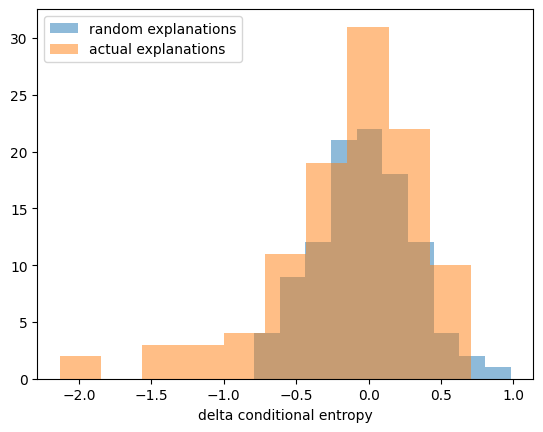

In [21]:
import matplotlib.pyplot as plt
plt.hist(all_df["max_delta_conditional_entropy"], alpha=0.5, label="random explanations")
plt.hist(random_explanations_df["max_delta_conditional_entropy"], alpha=0.5, label="actual explanations")
plt.xlabel("delta conditional entropy")
plt.legend()


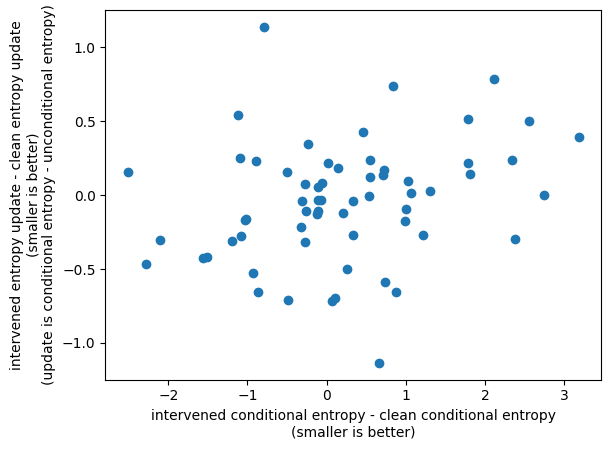

In [ ]:
import matplotlib.pyplot as plt
delta_CEs = all_df["max_delta_conditional_entropy"]
delta_updates = all_df["max_delta_entropy_update"]

# surprisal update is the negative log bayes factor of the conditional model over the unconditional model
plt.scatter(delta_CEs, delta_updates)
plt.xlabel("intervened conditional entropy - clean conditional entropy\n(smaller is better)")
plt.ylabel("intervened entropy update - clean entropy update\n(smaller is better)\n(update is conditional entropy - unconditional entropy)")
plt.show()

In [ ]:
from scipy.stats import pearsonr

pearsonr(delta_CEs, delta_updates)

PearsonRResult(statistic=0.2628887859651209, pvalue=0.038986870959337394)

In [8]:
import pandas as pd
all_df = pd.read_json("counterfactual_results/generations_gemma-2-9b_32layer_300feats.json")
all_df.to_dict(orient="records")[0]["completions"]

[{'text': " pretty good sense of humor)I love that lunch! So cute!\nThe Rainbow Jen\nWhen I was in grade school, my BFF's mom took a",
  'max_act': 30.171875,
  'completions': {'clean': ' bunch of girls to that restaurant and I',
   'intervened': 'Personensuche beginnetjesetVerticalGroup Taktlose TaktlosesetVerticalGroup Numerade invokingState'}},
 {'text': ',',
  'max_act': 14.15625,
  'completions': {'clean': "\n                  'id': str(uuid",
   'intervened': 'hilangan-------------</ lộ Taktlose bevestig Taktlose lộ Taktlose'}},
 {'text': '’s drug and alcohol policy.\nThe boy’s mother contacted me 2 days ago the very afternoon her son was suspended in a plea to help her resolve the situation.\nThe trouble apparently started',
  'max_act': 9.53125,
  'completions': {'clean': ' when her son went into the toilet during',
   'intervened': ".< We'{{\ufeff// {{\ufeff//\ufeff//"}},
 {'text': '\nMorren, George\nGeorge Morren 1868-1941 · Belgian Le Renouveau (The Renewal) Signed "G.',
  '